In [1]:
from regimetry.utils.path_utils import get_project_root
from regimetry.config import Config
from regimetry.services.data_transformation_service import DataTransformationService
from regimetry.logger_manager import LoggerManager
from regimetry.models.rolling_windows_generator import RollingWindowGenerator

import tensorflow as tf
from regimetry.models.positional_encoding import PositionalEncoding


import numpy as np
import matplotlib.pyplot as plt


In [2]:


logging = LoggerManager.get_logger("positional_encoding.ipynb")

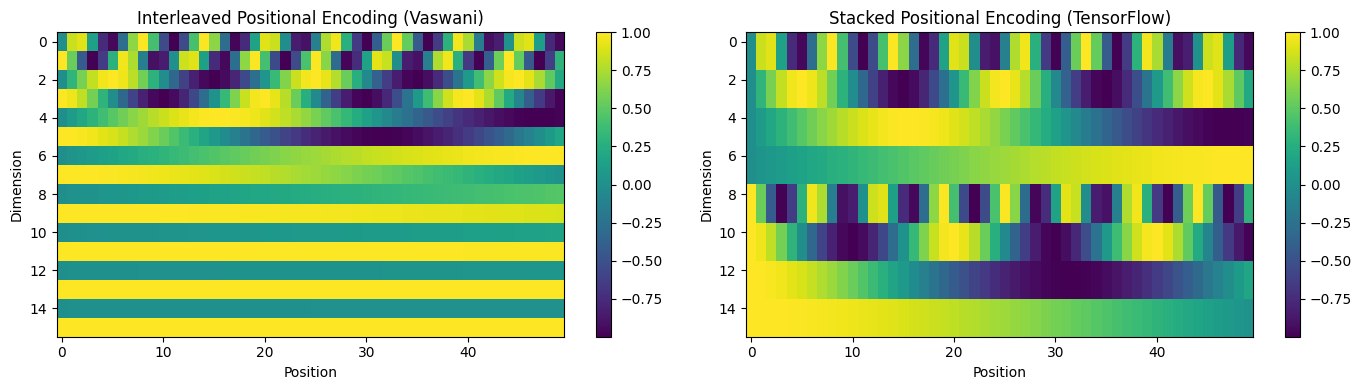

In [3]:

# Set parameters
position = np.arange(0, 50)  # 50 positions
d_model = 16  # embedding dimension
half_d_model = d_model // 2

# Compute the positional encodings (same logic as in Vaswani et al.)
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos[:, np.newaxis] * angle_rates

angle_rads = get_angles(np.arange(50), np.arange(d_model), d_model)

# Interleaved: sin at even, cos at odd indices
interleaved_pe = np.copy(angle_rads)
interleaved_pe[:, 0::2] = np.sin(interleaved_pe[:, 0::2])
interleaved_pe[:, 1::2] = np.cos(interleaved_pe[:, 1::2])

# Stacked: first half sin, second half cos
stacked_pe = np.zeros_like(angle_rads)
stacked_pe[:, :half_d_model] = np.sin(angle_rads[:, :half_d_model])
stacked_pe[:, half_d_model:] = np.cos(angle_rads[:, :half_d_model])

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
im1 = axes[0].imshow(interleaved_pe.T, aspect='auto', cmap='viridis')
axes[0].set_title("Interleaved Positional Encoding (Vaswani)")
axes[0].set_xlabel("Position")
axes[0].set_ylabel("Dimension")
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(stacked_pe.T, aspect='auto', cmap='viridis')
axes[1].set_title("Stacked Positional Encoding (TensorFlow)")
axes[1].set_xlabel("Position")
axes[1].set_ylabel("Dimension")
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


In [4]:
project_root = get_project_root()
project_root

'/Users/kenneth/Public/projects/python/ai/regimetry'

In [5]:

cfg = Config()
print("PROJECT ROOT:", cfg.PROJECT_ROOT)
print("BASE DIR:", cfg.BASE_DIR)
print("RAW DATA:", cfg.RAW_DATA_DIR)
print("PROCESSED DATA:", cfg.PROCESSED_DATA_DIR)

PROJECT ROOT: /Users/kenneth/Public/projects/python/ai/regimetry
BASE DIR: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts
RAW DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/data/raw
PROCESSED DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/data/processed


In [ ]:
data_transformation_service = DataTransformationService()
train_arr, preprocessor_obj = (
    data_transformation_service.initiate_data_transformation()
)


[ 2025-05-12 08:34:44 ] INFO [../../src/regimetry/services/data_transformation_service.py:134] - 📁 Loaded full dataset for transformation.
[ 2025-05-12 08:34:44 ] INFO [../../src/regimetry/services/data_transformation_service.py:60] - Including columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Predictions', 'Confidence', 'ATR', 'AHMA', 'Leavitt_Projection', 'Leavitt_Convolution', 'LC_Slope', 'LC_Intercept', 'LC_Acceleration', 'Convolution_Probability', 'Baseline_Bullish', 'Baseline_Bearish', 'Baseline_Valid', 'ML_Trade_Direction', 'ML_Signal_Quality', 'ML_Confirmed', 'LC_Acceleration_Shift', 'LC_Slope_Shift', 'LC_Acceleration_STD', 'LC_Slope_STD', 'Threshold', 'Confirm_Threshold', 'Trend', 'Trend_Within_Threshold', 'Confirmed_Trend', 'Confirmed_Trend_Within_Threshold', 'Stop_Loss_Price', 'Take_Profit_1_Price', 'Take_Profit_2_Price', 'SL_Pips', 'TP1_Pips', 'TP2_Pips', 'SL_Ticks', 'TP1_Ticks', 'TP2_Ticks', 'News_Conflict', 'Prevailing_Trend', 'Baseline_Aligned', 'Trend_Agreement', 'LC

In [7]:

logging.info("🧊 Generating rolling windows.")
if hasattr(train_arr, "toarray"):  # Handle sparse matrix if returned
    train_arr = train_arr.toarray()
window_gen = RollingWindowGenerator(
    data=train_arr,
    window_size=30
)
rolling_windows = window_gen.generate()
logging.info(f"✅ Rolling windows generated: shape={rolling_windows.shape}")


[ 2025-05-12 08:34:44 ] INFO [../../../../../../../../../var/folders/4q/cv174s2d24n6j71rjjzfsk6w0000gn/T/ipykernel_20139/3777317547.py:1] - 🧊 Generating rolling windows.
[ 2025-05-12 08:34:44 ] INFO [../../../../../../../../../var/folders/4q/cv174s2d24n6j71rjjzfsk6w0000gn/T/ipykernel_20139/3777317547.py:9] - ✅ Rolling windows generated: shape=(1840, 30, 80)


In [8]:


X = tf.convert_to_tensor(rolling_windows, dtype=tf.float32)
print(f"X shape: {X.shape}")
X_pe = PositionalEncoding.add(X, method='sinusoidal')
print(f"X_pe shape: {X_pe.shape}")


X shape: (1840, 30, 80)
X_pe shape: (1840, 30, 80)


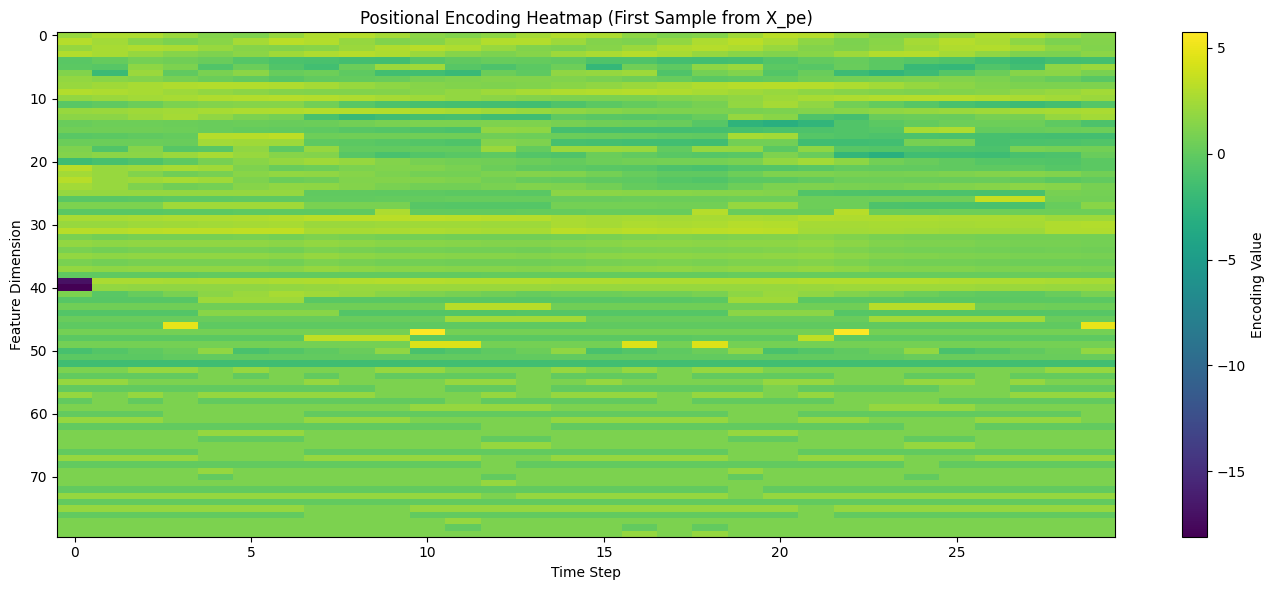

In [9]:
# Select 1st window for visualization
x_pe_sample = X_pe[0].numpy()  # shape: (30, 80)

# Plot heatmap (transpose for [dimension x time] view)
plt.figure(figsize=(14, 6))
plt.imshow(x_pe_sample.T, aspect='auto', cmap='viridis')
plt.title("Positional Encoding Heatmap (First Sample from X_pe)")
plt.xlabel("Time Step")
plt.ylabel("Feature Dimension")
plt.colorbar(label="Encoding Value")
plt.tight_layout()
plt.show()

1. 🔍 Zoom in on first 256 dimensions:

Text(0.5, 1.0, 'Zoomed: First 256 Embedding Dimensions')

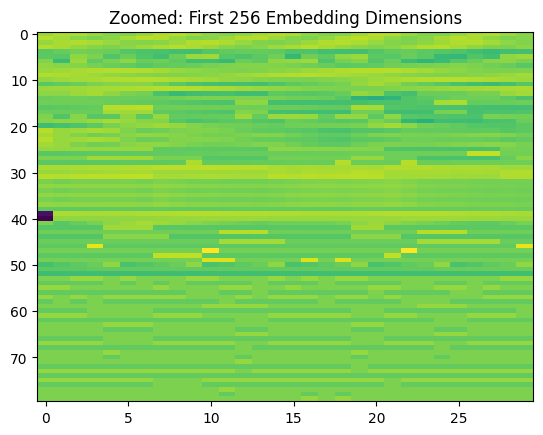

In [10]:
plt.imshow(x_pe_sample[:, :256].T, aspect='auto', cmap='viridis')
plt.title("Zoomed: First 256 Embedding Dimensions")


2. 📉 Plot positional encoding values for specific dimensions:

Text(0.5, 1.0, 'Positional Encoding Values Over Time (Selected Dims)')

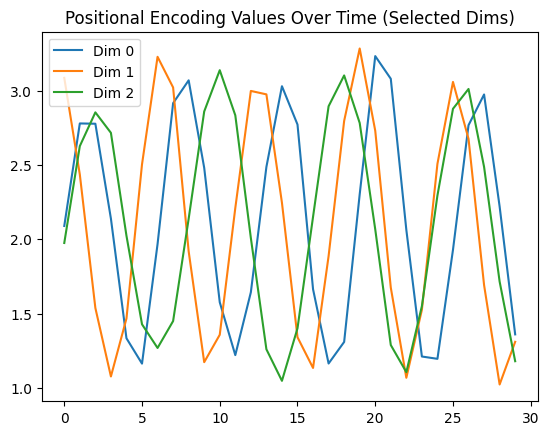

In [11]:
plt.plot(x_pe_sample[:, 0], label='Dim 0')
plt.plot(x_pe_sample[:, 1], label='Dim 1')
plt.plot(x_pe_sample[:, 2], label='Dim 2')
plt.legend()
plt.title("Positional Encoding Values Over Time (Selected Dims)")

🔢 Plot encoding for selected dimensions:

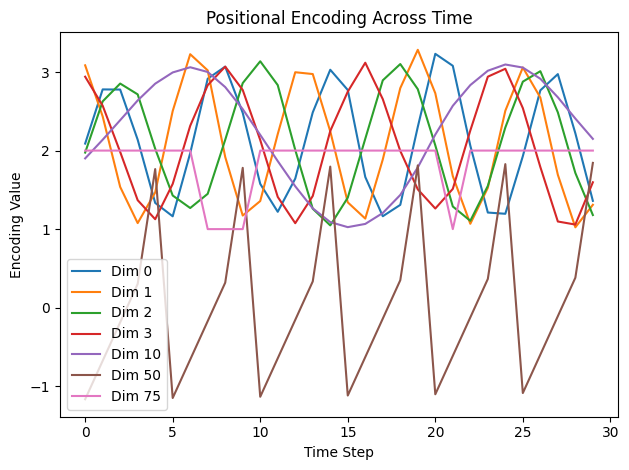

In [12]:


dims_to_plot = [0, 1, 2, 3, 10, 50, 75]
for i in dims_to_plot:
    plt.plot(x_pe_sample[:, i], label=f"Dim {i}")
plt.title("Positional Encoding Across Time")
plt.xlabel("Time Step")
plt.ylabel("Encoding Value")
plt.legend()
plt.tight_layout()
plt.show()

🧪 Verify that even/odd channels alternate sinusoidally:

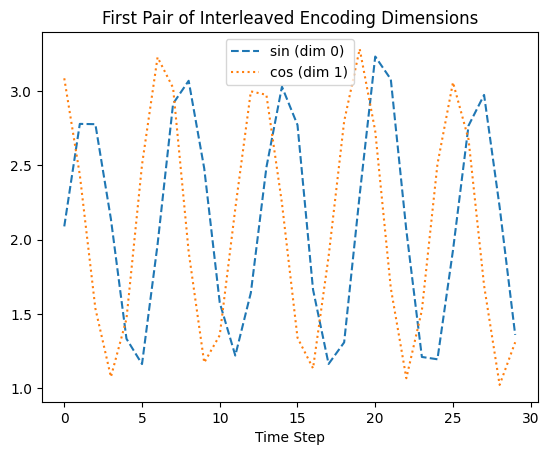

In [13]:
plt.plot(x_pe_sample[:, 0], label="sin (dim 0)", linestyle="--")
plt.plot(x_pe_sample[:, 1], label="cos (dim 1)", linestyle=":")
plt.title("First Pair of Interleaved Encoding Dimensions")
plt.xlabel("Time Step")
plt.legend()
plt.show()


In [14]:
X_pe_stacked = PositionalEncoding.add(X, method='sinusoidal', encoding_style='stacked')
print(f"X_pe_stacked shape: {X_pe_stacked.shape}")


X_pe_stacked shape: (1840, 30, 80)


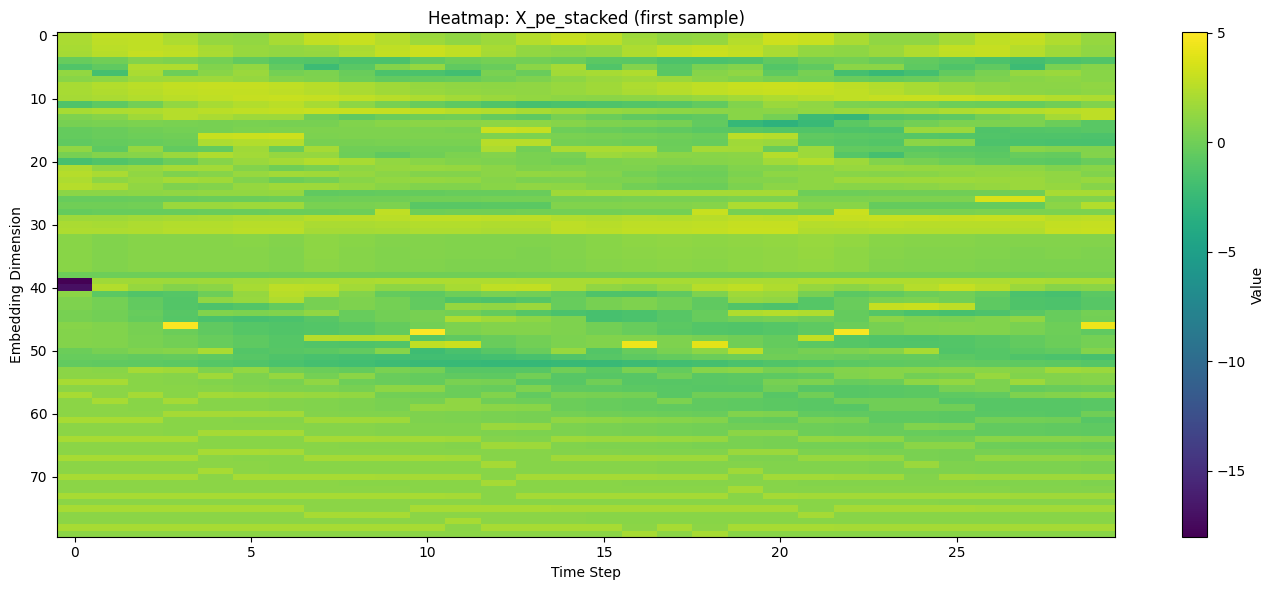

In [15]:
# Extract the first sample (shape: [30, 80])
x_pe_stacked_sample = X_pe_stacked[0].numpy()

plt.figure(figsize=(14, 6))
plt.imshow(x_pe_stacked_sample.T, aspect='auto', cmap='viridis')
plt.title("Heatmap: X_pe_stacked (first sample)")
plt.xlabel("Time Step")
plt.ylabel("Embedding Dimension")
plt.colorbar(label="Value")
plt.tight_layout()
plt.show()

In [16]:
X_pe_learned = PositionalEncoding.add(X, method='learnable', learnable_dim=80)
print(f"X_pe_learned shape: {X_pe_learned.shape}")

X_pe_learned shape: (1840, 30, 80)


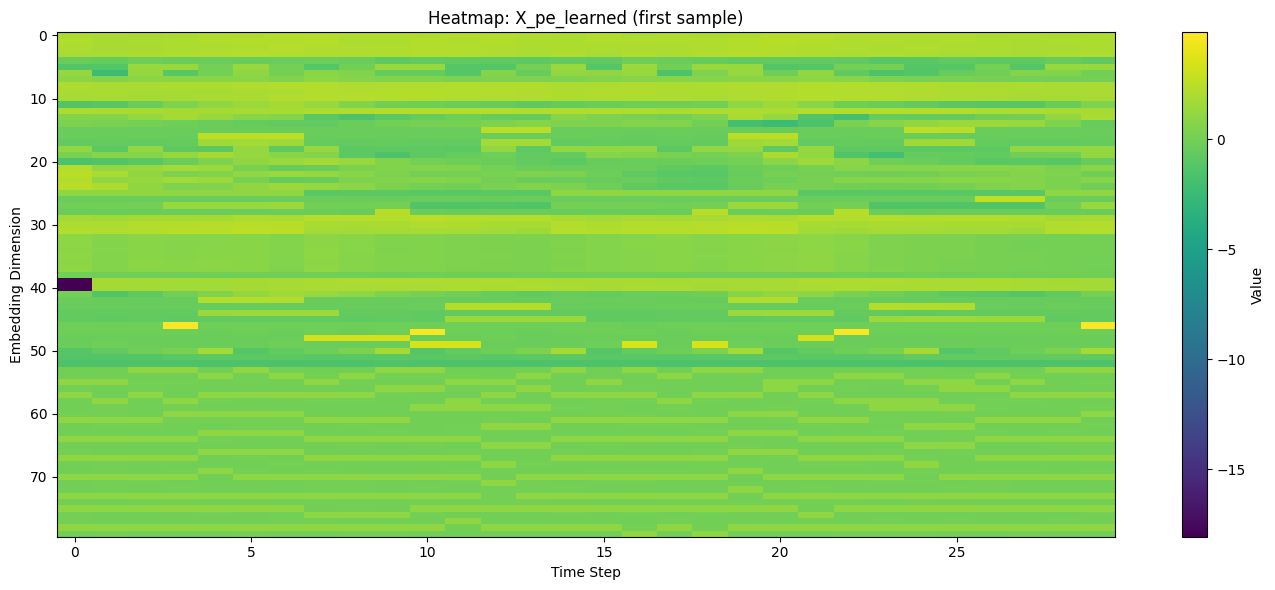

In [17]:
x_pe_learned_sample = X_pe_learned[0].numpy()  # shape: (30, 80)

plt.figure(figsize=(14, 6))
plt.imshow(x_pe_learned_sample.T, aspect='auto', cmap='viridis')
plt.title("Heatmap: X_pe_learned (first sample)")
plt.xlabel("Time Step")
plt.ylabel("Embedding Dimension")
plt.colorbar(label="Value")
plt.tight_layout()
plt.show()

🧠 Interpretation
- This is exactly what untrained learnable encodings look like.

- They're randomly initialized and will only become useful once:

    - The model begins training
    - Backpropagation adjusts their values to encode position meaningfully



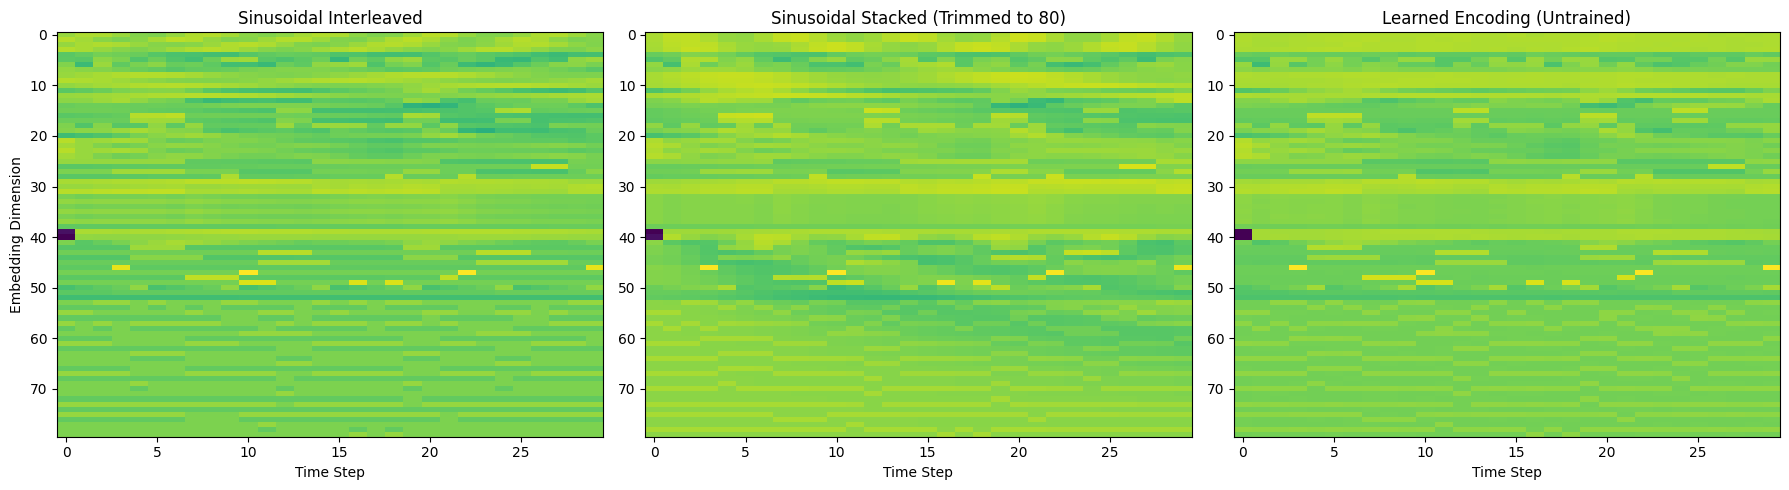

In [18]:
# Extract the first sample from each encoding tensor
# Trim stacked to match others for side-by-side comparison
x_pe_stacked_trimmed = x_pe_stacked_sample[:, :80]

# Plot all three encodings side-by-side
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].imshow(x_pe_sample.T, aspect='auto', cmap='viridis')
axs[0].set_title("Sinusoidal Interleaved")
axs[0].set_xlabel("Time Step")
axs[0].set_ylabel("Embedding Dimension")

axs[1].imshow(x_pe_stacked_trimmed.T, aspect='auto', cmap='viridis')
axs[1].set_title("Sinusoidal Stacked (Trimmed to 80)")
axs[1].set_xlabel("Time Step")

axs[2].imshow(x_pe_learned_sample.T, aspect='auto', cmap='viridis')
axs[2].set_title("Learned Encoding (Untrained)")
axs[2].set_xlabel("Time Step")

plt.tight_layout()
plt.show()